# Install + Import Libraries

In [ ]:
!pip install kagglehub joblib -q

import kagglehub, os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from joblib import Parallel, delayed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Download Dataset

In [ ]:
dataset_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Dataset Path:", dataset_path)

train_df = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
test_df  = pd.read_csv(os.path.join(dataset_path, "Test.csv"))
meta_df  = pd.read_csv(os.path.join(dataset_path, "Meta.csv"))

BASE_FOLDER = dataset_path
num_classes = len(meta_df)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Dataset Path: /kaggle/input/gtsrb-german-traffic-sign


# Helper Functions for Image Loading

In [ ]:
def read_img(path, size=(32,32)):
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        return img
    return None

def load_images(df, base_folder, has_labels=True):
    paths = [os.path.join(base_folder, p) for p in df['Path']]
    imgs = Parallel(n_jobs=-1)(delayed(read_img)(p) for p in paths)
    imgs = np.array([im for im in imgs if im is not None], dtype="float32") / 255.0
    labels = df['ClassId'].values if has_labels and 'ClassId' in df.columns else None
    return imgs, labels

X_train, y_train = load_images(train_df, BASE_FOLDER, has_labels=True)
X_test, y_test   = load_images(test_df, BASE_FOLDER, has_labels=('ClassId' in test_df.columns))

y_train = to_categorical(y_train, num_classes=num_classes)
if y_test is not None:
    y_test = to_categorical(y_test, num_classes=num_classes)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, None if y_test is None else y_test.shape)

Train: (31367, 32, 32, 3) (31367, 43)
Val: (7842, 32, 32, 3) (7842, 43)
Test: (12630, 32, 32, 3) (12630, 43)


# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Custom CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,523 (923.92 KB)

 Trainable params: 236,075 (922.17 KB)

 Non-trainable params: 448 (1.75 KB)

# Training

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=15,
    verbose=1
)

Epoch 1/15
 20/491 ━━━━━━━━━━━━━━━━━━━━ 1:06 141ms/step - accuracy: 0.9826 - loss: 0.0624

KeyboardInterrupt: 

# Evaluation

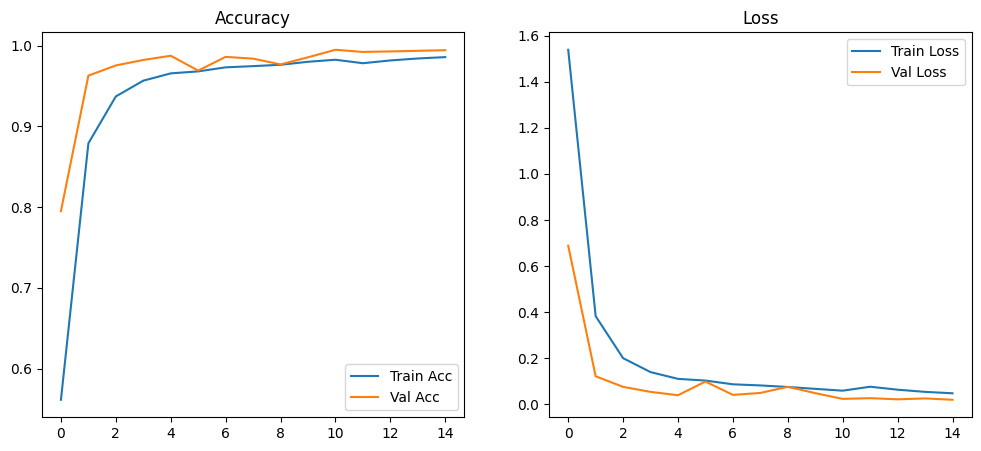

✅ Test Accuracy: 0.9606, Test Loss: 0.1978
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


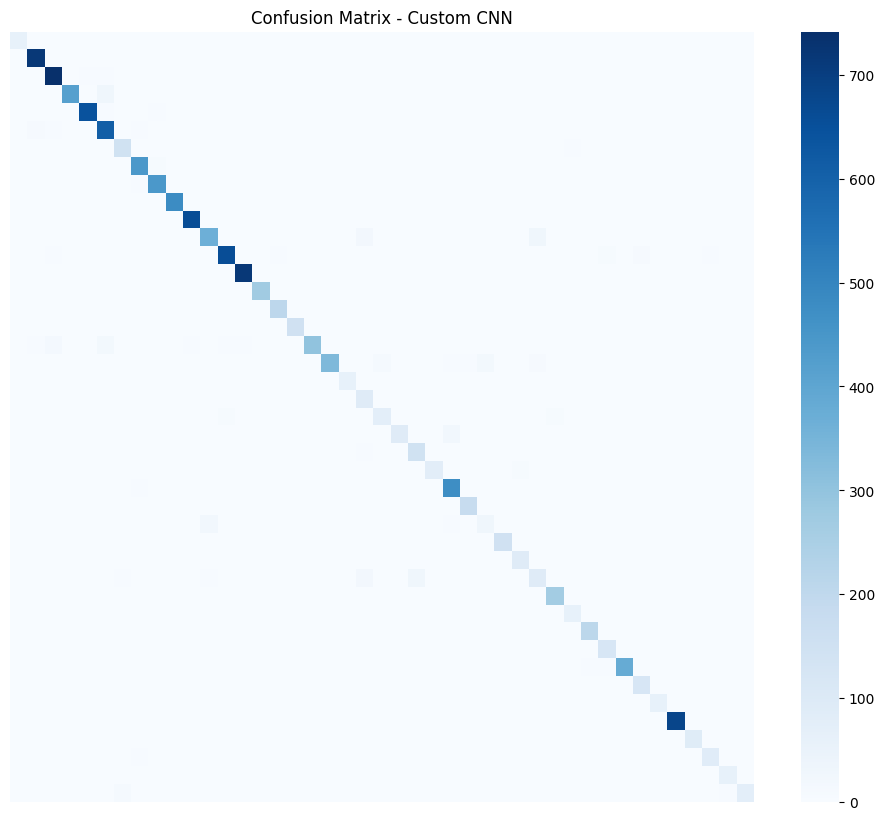

In [ ]:
#Accuracy/Loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")

plt.show()

#Test evaluation
if y_test is not None:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    #Confusion matrix
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
    plt.title("Confusion Matrix - Custom CNN")
    plt.show()


# Run a Test Video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Clean meta_df column names
meta_df.columns = meta_df.columns.str.strip()
label_col = [c for c in meta_df.columns if c.lower() != "classid"][0]
label_map = dict(zip(meta_df['ClassId'], meta_df[label_col]))

# --- Detection + Classification function ---
def detect_signs(frame, model, label_map, input_size=(32,32), conf_thresh=0.6):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Red mask (traffic signs usually have red borders)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Filter small/huge boxes (noise)
        if w > 20 and h > 20 and w < frame.shape[1] and h < frame.shape[0]:
            roi = frame[y:y+h, x:x+w]
            roi_resized = cv2.resize(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB), input_size) / 255.0
            roi_resized = np.expand_dims(roi_resized, axis=0)

            preds = model.predict(roi_resized, verbose=0)
            class_id = np.argmax(preds)
            conf = np.max(preds)

            if conf > conf_thresh:
                label = f"{label_map[class_id]} ({conf*100:.1f}%)"
                cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (0,255,0), 2)

    return frame


# --- Video processing ---
video_path = "/content/drive/MyDrive/test_video.mp4"
cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect + classify traffic signs
    processed_frame = detect_signs(frame, model, label_map)

    if out is None:
        out = cv2.VideoWriter("output_predictions.mp4", fourcc, 20,
                              (frame.shape[1], frame.shape[0]))
    out.write(processed_frame)

cap.release()
if out: out.release()
cv2.destroyAllWindows()

print("🎥 Saved processed video with bounding boxes as output_predictions.mp4")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎥 Saved processed video with bounding boxes as output_predictions.mp4


# Move the Video to Drive

In [ ]:
!cp /content/output_predictions.mp4 /content/drive/MyDrive/
